In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

The Second Order Runge-Kutta Method is defined by
$$ F_{1,n}=f(t_n,x_n)$$
$$ F_{2,n}=f(t_n+\alpha h,x_n+\alpha h F_{1,n})$$
$$ x_{n+1}=x_n+\beta hF_{1,n}+\gamma hF_{2,n}$$
where $\beta+\gamma=1$ and $\alpha \gamma=\frac{1}{2}$. In this case I have chosen $\beta=\gamma=\frac{1}{2}$ and $\alpha=1$.

In [4]:
def rk2(t,x,f,h,*args): # I have chosen alpha=1 and beta=gamma=0.5
    F1 = f(t,x,*args)
    F2 = f(t+h,x+h*F1,*args)
    return x + 0.5*h*F1+0.5*h*F2

The Quasi-Second Order Adams-Bashforth II method we use is defined as:
$$ u^{n+1}=u^n+\Delta t G^{(n+\frac{1}{2})}_{u}$$
$$ G^{(n+\frac{1}{2})}_{u}=(\frac{3}{2}+\epsilon_{AB})G^{(n)}_{u}-(\frac{1}{2}+\epsilon_{AB})G^{(n-1)}_{u}$$
Note that we use RK2 for the first two steps to initialize the method.

In [5]:
def QSAB(t,x,f,h,Gn,Gn1,*args):
    eps = 0
    Gn12 = (1.5+eps)*f(t,Gn,*args)-(0.5+eps)*f(t,Gn1,*args)
    xn1 = x + h*Gn12
    return xn1

Below we define the system of equations the solver is resolving, they are
$$ \dfrac{\partial u}{\partial t}=fv+\nu_E\dfrac{\partial^2 u}{\partial z^2}$$
$$ \dfrac{\partial v}{\partial t}=f(\bar{u}-u)+\nu_E\dfrac{\partial^2 v}{\partial z^2}$$
where 
$$ \dfrac{\partial^2 u}{\partial z^2}\approx \dfrac{u(z+\Delta z)-2u(z)+u(z-\Delta z)}{\Delta z^2}$$
$$ \dfrac{\partial^2 v}{\partial z^2}\approx \dfrac{v(z+\Delta z)-2v(z)+v(z-\Delta z)}{\Delta z^2}.$$
Note that we assume at the bottom $u=v=0$ for all times and that $\dfrac{\partial u}{\partial z}=\dfrac{\partial u}{\partial z}=0$ at the top so that the second partial derivative term is 0 at the top.

In [6]:
def dudt(t,v,f,vE,u_prev,dz,j):
    dudz = (u_prev[j+1]-2*u_prev[j]+u_prev[j-1])/(dz**2) # second derivative for u wrt z
    out = f*v+vE*dudz # full equation for the derivative of u wrt t
    return out

In [7]:
def dvdt(t,u,f,vE,v_prev,dz,j,u_bar):
    dvdz = (v_prev[j+1]-2*v_prev[j]+v_prev[j-1])/(dz**2) # second derivative for v wrt z
    out = f*(u_bar-u)+vE*dvdz # full equation for the derivative of v wrt t
    return out

In [8]:
dz = 1 # vertical resolution
z = np.arange(-100.1,0,dz) # calculate vertical points
u_bar = 0.25 # mean flow away from Ekman Layer
u_prev = np.append(u_bar*np.ones(z.shape[0]-1),0).tolist() # define initial conditions
v_prev = np.append(0,0*np.ones(z.shape[0]-1)).tolist()
data_u = np.array([u_prev]) # store initial conditions in a numpy array
data_v = np.array([v_prev])
h = 0.005 # steps size
total = 10 # total amount of time the model is run
T = np.arange(0,total,h) # time domain
omega = 7.2921*10**(-5) # rotation frequenct
phi = 45 #latitude
f = 2*omega*np.sin(np.radians(phi)) # coriolis parameter
vE = 1*10**(-2) # eddy viscosity
uGn = u_prev
vGn = v_prev
for i in T[:2]: # iterate over time domain
    u = [0] # bottom conditions
    v = [0]
    for k in range(len(z[1:-1])):
        j=k+1
        ui=rk2(i,v_prev[j],dudt,h,f,vE,u_prev,dz,j) # run the model at each vertical point
        vi=rk2(i,u_prev[j],dvdt,h,f,vE,v_prev,dz,j,u_bar)
        u.append(ui)
        v.append(vi)
    u.append(u_bar) # top conditions
    v.append(0.01)
    new_data_u = np.array([u]) # store the data
    new_data_v = np.array([v])
    data_u = np.append(data_u,new_data_u,axis=0) # data u and data v have the data from each time step stored,
    data_v = np.append(data_v,new_data_v,axis=0) # with the first dimension serving as time and second as point in z
    u_prev = u
    v_prev = v
    uGn1 = uGn
    vGn1 = vGn
    uGn = u_prev
    vGn = v_prev
for i in T[2:]: # iterate over time domain
    u = [0] # bottom conditions
    v = [0]
    for k in range(len(z[1:-1])):
        j=k+1
        ui=QSAB(i,v_prev[j],dudt,h,uGn[j],uGn1[j],f,vE,u_prev,dz,j) # run the model at each vertical point
        vi=QSAB(i,u_prev[j],dvdt,h,vGn[j],vGn1[j],f,vE,v_prev,dz,j,u_bar)
        u.append(ui)
        v.append(vi)
    u.append(u_bar) # top conditions
    v.append(0.01)
    new_data_u = np.array([u]) # store the data
    new_data_v = np.array([v])
    data_u = np.append(data_u,new_data_u,axis=0) # data u and data v have the data from each time step stored,
    data_v = np.append(data_v,new_data_v,axis=0) # with the first dimension serving as time and second as point in z
    u_prev = u
    v_prev = v
    uGn1 = uGn
    vGn1 = vGn
    uGn = u_prev
    vGn = v_prev

Below calculates the Ekman depth:

In [9]:
d = np.sqrt(2*vE/f)
print(f"The Ekman Depth is {d}")

The Ekman Depth is 13.926153923816038


Below are contour plots for the components of velocity.

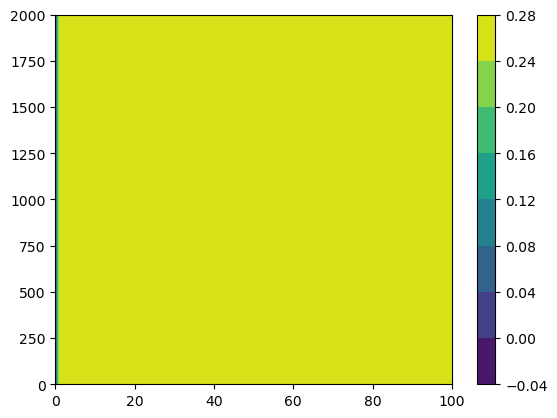

In [10]:
cs = plt.contourf(data_u)
plt.colorbar(cs)

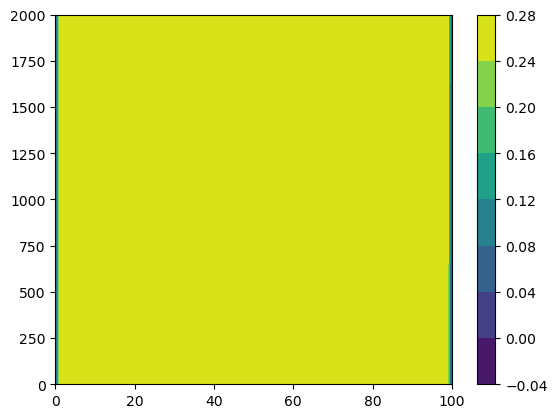

In [11]:
cs = plt.contourf(data_v)
plt.colorbar(cs)

Below are the plots of the u and v components of velocity in the water column at a specific time.

Text(0, 0.5, 'depth')

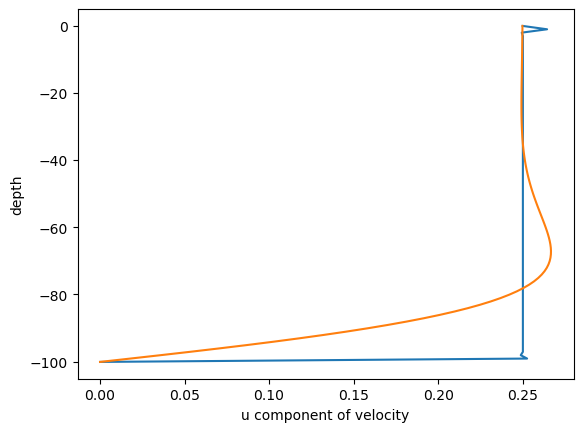

In [12]:
time = -1# time
zn = np.arange(0,101,1)
plt.plot(data_u[time],z)
plt.plot(u_bar*(1-np.exp(-zn/d)*np.cos(zn/d)),z)
plt.xlabel("u component of velocity")
plt.ylabel("depth")

Text(0, 0.5, 'depth')

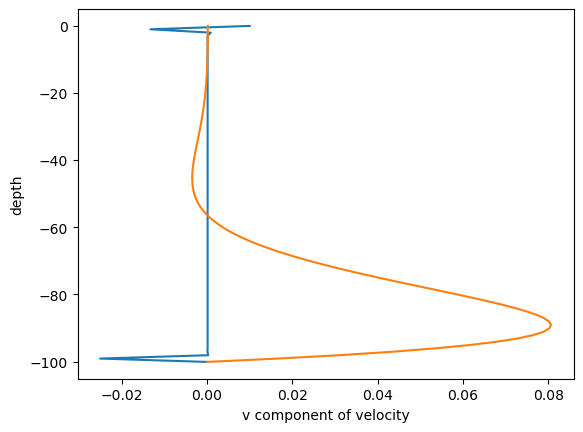

In [13]:
plt.plot(data_v[time],z)
plt.plot(u_bar*np.exp(-zn/d)*np.sin(zn/d),z)
plt.xlabel("v component of velocity")
plt.ylabel("depth")

In [14]:
V = np.sum(dz*data_v[-1])
print(f"The net transport of fluid is {V}")

The net transport of fluid is -0.015026264552522104
